# Categorical and Missing Data

In this session we will work with short-term housing rental data. The goal is to predict the review scores rating. 

There are many entries (i.e rows) with missing attributes in our dataset. 

We will come around this issue by employing two approaches:
1. *Remove rows with missing values*
2. *Single imputation with median*

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import os

## Load Raw Data

In [2]:
# Load data
if os.path.exists('abnb_listings.csv'):
    df = pd.read_csv('abnb_listings.csv')
else:
    # df = pd.read_csv('http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2018-01-17/data/listings.csv.gz', 
    #                   compression='gzip')
    df = pd.read_csv('https://raw.githubusercontent.com/InfoTUNI/joda2022/master/koodiesimerkit/data.csv', 
                      )
    df.to_csv('abnb_listings.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 97 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        16313 non-null  int64  
 1   id                                16313 non-null  int64  
 2   listing_url                       16313 non-null  object 
 3   scrape_id                         16313 non-null  int64  
 4   last_scraped                      16313 non-null  object 
 5   name                              16302 non-null  object 
 6   summary                           15860 non-null  object 
 7   space                             11798 non-null  object 
 8   description                       16305 non-null  object 
 9   experiences_offered               16313 non-null  object 
 10  neighborhood_overview             10343 non-null  object 
 11  notes                             6734 non-null   object 
 12  tran

### First Approach - Removing rows with missing values

In [3]:
# We will focus on three attributes only
df_rem = df[['host_response_time','host_response_rate','review_scores_rating']].copy()

print(df_rem.head())
print(df_rem.host_response_time.unique())

  host_response_time host_response_rate  review_scores_rating
0       within a day                60%                  89.0
1     within an hour               100%                  91.0
2     within an hour               100%                  79.0
3     within an hour               100%                  90.0
4     within an hour               100%                  80.0
['within a day' 'within an hour' 'within a few hours' nan
 'a few days or more']


In [9]:
df_rem.host_response_rate = df_rem.host_response_rate.str.strip('%')
df_rem.host_response_rate = pd.to_numeric(df_rem.host_response_rate)

print(df_rem.info(), '\n')
print(df_rem.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_time    13805 non-null  object 
 1   host_response_rate    13805 non-null  float64
 2   review_scores_rating  13118 non-null  float64
dtypes: float64(2), object(1)
memory usage: 382.5+ KB
None 

  host_response_time  host_response_rate  review_scores_rating
0       within a day                60.0                  89.0
1     within an hour               100.0                  91.0
2     within an hour               100.0                  79.0
3     within an hour               100.0                  90.0
4     within an hour               100.0                  80.0


In [10]:
# Remove all rows with null values
df_rem = df_rem.dropna()

In [11]:
df_rem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11855 entries, 0 to 16218
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_time    11855 non-null  object 
 1   host_response_rate    11855 non-null  float64
 2   review_scores_rating  11855 non-null  float64
dtypes: float64(2), object(1)
memory usage: 370.5+ KB


In [14]:
# Converting host_response_time attribute to categorical values.

# Encoding label encoder...
le = preprocessing.LabelEncoder()

arr = le.fit_transform(df_rem.host_response_time)

df_rem.host_response_time = arr

In [15]:
print(arr)
df_rem.head()

[1 3 3 ... 3 3 3]


,host_response_time,host_response_rate,review_scores_rating
0,1,60.0,89.0
1,3,100.0,91.0
2,3,100.0,79.0
3,3,100.0,90.0
4,3,100.0,80.0


In [16]:
# Perform Linear Regression
lr = linear_model.LinearRegression()

# define labels and data (i.e y and X)
y = df_rem.review_scores_rating
X = df_rem.drop(columns='review_scores_rating')

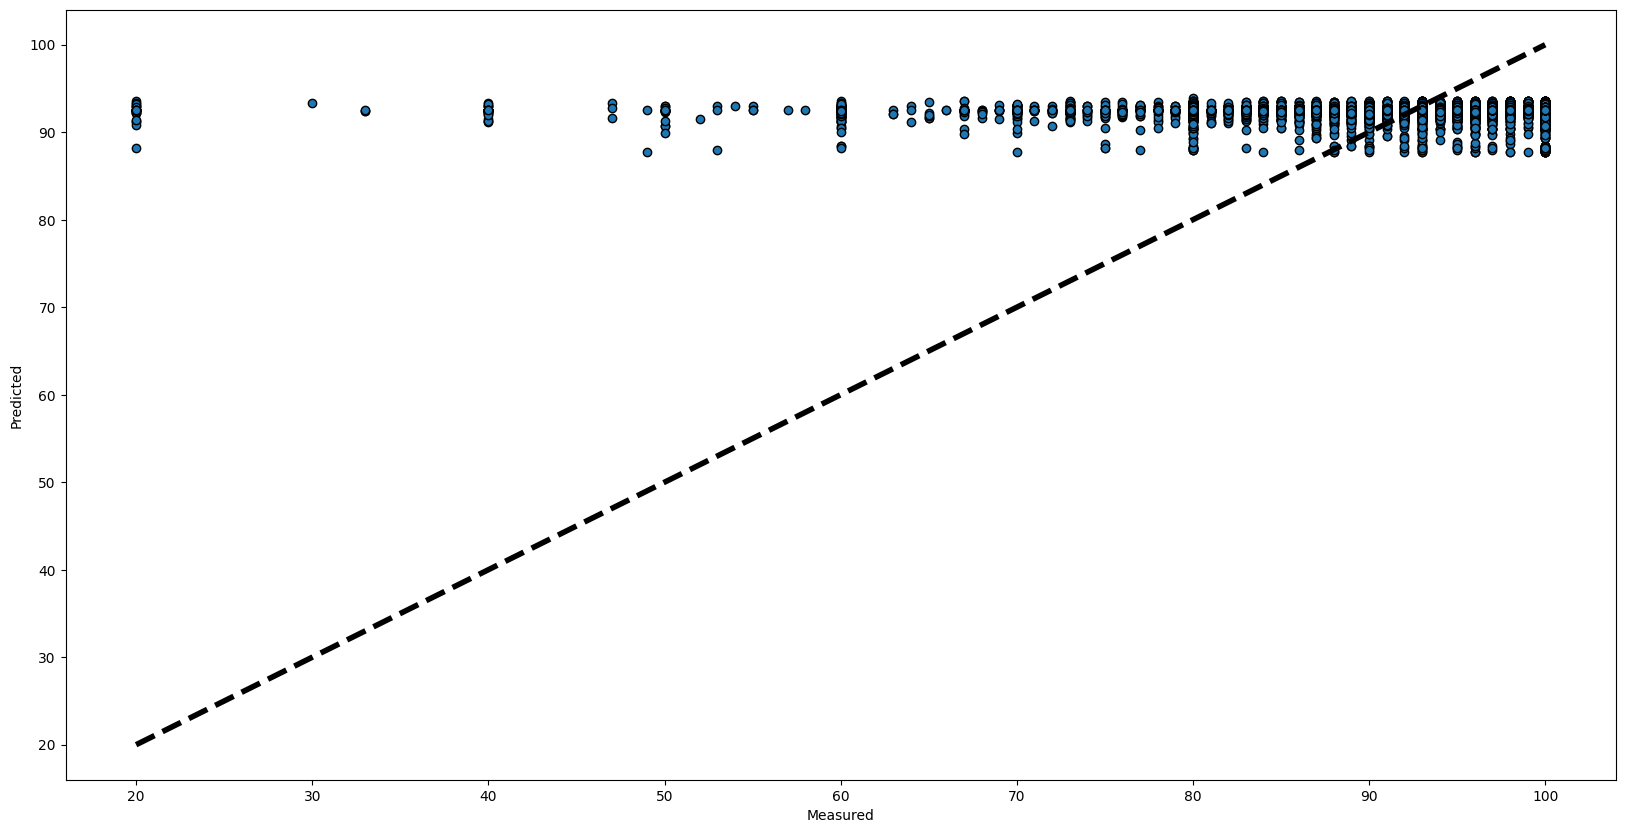

In [16]:
prediction = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(y, prediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [17]:
# Print pearson correlation coefficient a.k.a standard correlation coefficient
print(df_rem.corr())


                      host_response_time  host_response_rate  \
host_response_time              1.000000            0.586101   
host_response_rate              0.586101            1.000000   
review_scores_rating            0.018660            0.066256   

                      review_scores_rating  
host_response_time                0.018660  
host_response_rate                0.066256  
review_scores_rating              1.000000  


In [18]:
# Print Mean Squared Error
mse = mean_squared_error(prediction, y)
mae = mean_absolute_error(prediction, y)
print("Mean Squared Error {:.2f} \nMean Absolute Error {:.2f}".format(mse, mae))

Mean Squared Error 72.83 
Mean Absolute Error 5.72


### Second Approach - Single imputation with median.

In [19]:
#select a subset of attributes 
df_imp = df[['review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication',
         'review_scores_location','review_scores_value',
         'review_scores_rating']].copy()

print(df_imp.isnull().sum())

review_scores_accuracy         3208
review_scores_cleanliness      3202
review_scores_checkin          3224
review_scores_communication    3209
review_scores_location         3230
review_scores_value            3231
review_scores_rating           3195
dtype: int64


In [20]:
# Drop rows where all attributes are nan
df_imp.dropna(axis=0, how='all', inplace=True)

print(df_imp.isnull().sum())

review_scores_accuracy         14
review_scores_cleanliness       8
review_scores_checkin          30
review_scores_communication    15
review_scores_location         36
review_scores_value            37
review_scores_rating            1
dtype: int64


In [25]:
df_imp.median()

review_scores_accuracy         10.0
review_scores_cleanliness      10.0
review_scores_checkin          10.0
review_scores_communication    10.0
review_scores_location         10.0
review_scores_value             9.0
review_scores_rating           95.0
dtype: float64

In [21]:
# Impute median value for original missing values and generate new dataframe


df_imp = df_imp.fillna(df_imp.median())

print(df_imp.isnull().sum())

review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
review_scores_rating           0
dtype: int64


### Predicting review scores rating 

In [26]:
# Run Linear Regression
lr = linear_model.LinearRegression()

y = df_imp.review_scores_rating
X = df_imp.drop(columns='review_scores_rating')

prediction = cross_val_predict(lr, X, y, cv=10)

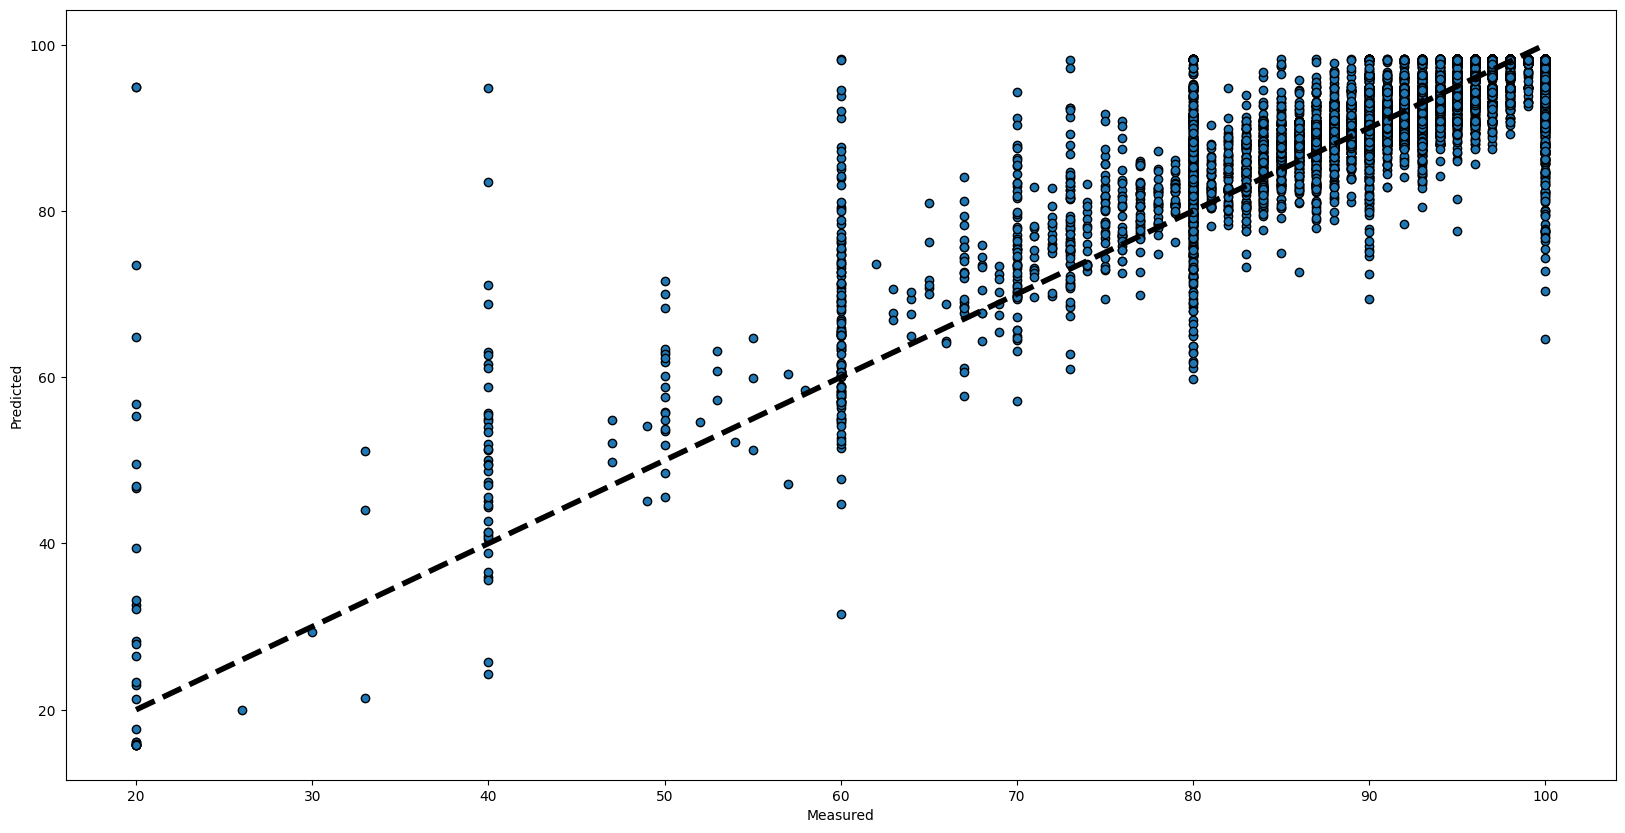

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y, prediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [29]:
print(df_imp.corr()['review_scores_rating'])

review_scores_accuracy         0.757929
review_scores_cleanliness      0.699975
review_scores_checkin          0.624204
review_scores_communication    0.656069
review_scores_location         0.418454
review_scores_value            0.793115
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64


In [30]:
# Print Mean Squared Error
mse = mean_squared_error(prediction, y)
mae = mean_absolute_error(prediction, y)
print("Mean Squared Error {:.2f} \nMean Absolute Error {:.2f}".format(mse, mae))

Mean Squared Error 19.60 
Mean Absolute Error 2.81


#### TODO TASK: 
Predict the review scores using the Random Forest Regressor model and evaluate the predictive performance.
Hint: Check out the sklearn implementation